In [1]:
def vertinterpolate(var,lev, zlev_int,method=None):
    """Interpolate data unified 0.5 km vertical levels. (except in the first km)

    The default uses numpy interp, but scipy interp1d can also be
    chosen via method="scipy". Scipy interp1d however is much slower.
    Based on a similar script by Aiko Voigt."""

    #import xarray as xr
    import numpy as np
    from scipy import interpolate

    var_int = np.zeros((len(zlev_int)))

    # loop over requested variables
    if method == "scipy":
        f_int = interpolate.interp1d(lev[:], var[:], bounds_error=False, kind="linear", fill_value="nan")
        var_int[:] = f_int(zlev_int)
    else:
        var_int[:] = np.interp(zlev_int[:], lev[:], var[:])
        
    return var_int

In [2]:
def shift_elements(arr, num, fill_value):
    """"shifting function, with a fill value;
        if just want to "roll it" use np.roll"""
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.nanargmin(np.abs(array - value))
    return idx #array[idx]

In [4]:
def legcolor(leg):
    "function that gives back the color of legend elements, even if they are markers"
    for artist, text in zip(leg.legendHandles, leg.get_texts()):
            try:
                legcol = artist.get_color()
            except:
                legcol = artist.get_facecolor()
            if isinstance(legcol, np.ndarray):
                legcol = legcol[0]
            text.set_color(legcol)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib import ticker
import copy
import xarray as xr

In [6]:
path = '../../data/RCEMIP_processed/'

ssts = ['295','305']
col = ['k','orange','crimson']

plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other

variables = ['hr_acre','ice_mixing_ratio','cloud_fraction','density','temperature','ice_water_content']
units = ['K/day','1','kg/kg']

ds = xr.open_dataset(path+'RCElarge_z24_merged_1D_averages_multiplevars2.nc')
models = ds['names_of_models'].values

In [7]:
#here additional regridding from 500 to 50 m vertical grid
# target vertical levels
zlev_int = np.arange(0, 24.001, 0.05) #50 m 
ssts = ['295','300','305']
models = ['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam','MPAS','UCLA-CRM','CAM5_GCM',
          'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1']

#1.) filter and regrid ACRE 
dataint={}  
ds['ice_water_content'] = ds['ice_mixing_ratio']*ds['density']
data_ice={}
data_temp={}
for v,variable in enumerate(variables):
    dataint[variable]={}
    #for m,model in enumerate(ds['names_of_models']):
    for m,model in enumerate(models):
        #print(model)
        dataint[variable][model]={}
        data_ice[model]={}
        data_temp[model]={}
        for s,sst in enumerate(ssts):
            dataint[variable][model][sst]={}
            data_ice[model][sst]={}
            data_temp[model][sst]={}
            rho0=ds['density'][m][s].values
            temp0 = ds['temperature'][m][s].values
            ice0=ds['ice_mixing_ratio'][m][s].values*rho0

            plotvar = (ds[variable][m,s]).values

            if variable=='density':
                pass
            else:
                #limit to locations with temperature < 273.15 K => upper troposphere
                plotvar[temp0>273.15] = 0. #np.nan
                #limit to troposphere, not interested in stratosphere, where no ice clouds and other processes more important (e.g. ozone)
                plotvar[ice0<1.e-8] = 0. #np.nan

            acre_interp = vertinterpolate(plotvar,ds['alt'].values,zlev_int,method='scipy')
            dataint[variable][model][sst]=acre_interp

            ice_interp = vertinterpolate(ice0,ds['alt'].values,zlev_int,method='scipy')
            temp_interp = vertinterpolate(temp0,ds['alt'].values,zlev_int,method='scipy')

            data_ice[model][sst] =ice_interp

            data_temp[model][sst]=temp_interp

In [8]:
temp_anom = np.zeros(len(models))
alt_cold = np.zeros(len(models))
temp_cold= np.zeros(len(models))
alt_warm = np.zeros(len(models))
isot_alt_shift = np.zeros(len(models))

dens_cold=np.zeros(len(models))
dens_fac = np.zeros(len(models))

iwc_cold=np.zeros(len(models))
iwc_fac = np.zeros(len(models))


for m,model in enumerate(models):
    alt_cold[m] = np.nanargmax(dataint['hr_acre'][model]['295'])*50 #alt in m (spacing is 50 m)
    temp_cold[m] = dataint['temperature'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])]
    
    alt_warm[m] = find_nearest(dataint['temperature'][model]['305'],temp_cold[m]) * 50 #alt in meters
    isot_alt_shift[m] = alt_warm[m] - alt_cold[m]
    
    temp_anom[m]= dataint['temperature'][model]['305'][np.nanargmax(dataint['hr_acre'][model]['305'])] - dataint['temperature'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])]

    #same but density at peak ACRE - we use rho(z) factor, this used only for IWC at peak ACRE
    dens_cold[m] = dataint['density'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])]
    dens_fac[m] = 1/(dataint['density'][model]['305'][np.nanargmax(dataint['hr_acre'][model]['305'])]/dataint['density'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])])

    #same but iwc at peak ACRE
    iwc_cold[m] = dataint['ice_water_content'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])]
    iwc_fac[m] = (dataint['ice_water_content'][model]['305'][np.nanargmax(dataint['hr_acre'][model]['305'])]/dataint['ice_water_content'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])])

here get the index and index2 for ideal and isothermal vertical shifts

In [9]:
models = ['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam','MPAS','UCLA-CRM','CAM5_GCM',
            'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1']

a_intensity = [1.45, 1.15, 1.28, 1.37, 1.24, 1.23, 1.51, 1.78, 0.73, 0.48, 1.82,
       0.73, 1.53, 1.58, 1.44, 1.35, 0.69, 0.91, 1.18] 

#optimal vertical shift, as per FINAL_geometry_zenodo.ipynb script
a_vertshift = [ 3450.,  3400.,  3200.,  3550.,  3050.,  2850.,  2000.,  3700.,
        2600., -1150.,  3100.,  4550.,  2850.,  2550.,  3000.,  3350.,
        3050.,  3150.,  2550.]


ph_cold_s2 = np.zeros((len(models),481))

for m,model in enumerate(models):
    #print(m,model)

    #"optimal shift"
    cold = dataint['hr_acre'][model]['295']
    index = int(a_vertshift[m]/50 )
    #print(index,'vertshift index')
    cold_s=shift_elements(cold,index,0)
    cold_si=a_intensity[m]*shift_elements(cold,index,0)

    #here done based on physical assumptions of isothermal shift
    index2 = int(isot_alt_shift[m]/50 )
    ph_cold_s=shift_elements(cold,index2,0) 
    ph_cold_s2[m]=ph_cold_s

    dens_shift=shift_elements(dataint['density'][model]['295'],index2,0)
    densfac=dens_shift/dataint['density'][model]['295']

here calculate again the RMS wint the new qi_fac and dens_fac and redo the plots

In [10]:
qi_intensity=iwc_fac*dens_fac  #here at max ACRE

In [11]:
rms = np.zeros(len(models))
rms_isoshift = np.zeros(len(models))

rms_idshift = np.zeros(len(models))
rms_intshift = np.zeros(len(models))

rms_densfac = np.zeros(len(models))
rms_densfac_ph = np.zeros(len(models))
rms_dens_qi = np.zeros(len(models))

e_isoshift = np.zeros(len(models))
e_idshift = np.zeros(len(models))
e_intshift = np.zeros(len(models))
e_densfac = np.zeros(len(models))
e_densfac_ph = np.zeros(len(models))
e_dens_qi = np.zeros(len(models))

rms_all = np.zeros((len(models),5))
e_all = np.zeros((len(models),5))
e_all_expl = np.zeros((len(models),5))

#intensity with vertshift, no scaling!
a_intensity =[1.45, 1.15, 1.28, 1.37, 1.24, 1.23, 1.51, 1.78, 0.73, 0.48, 1.82,
       0.73, 1.53, 1.58, 1.44, 1.35, 0.69, 0.91, 1.18]

#vertshift large shift only as per FINAL_geometry.ipynb
a_vertshift = [ 3450.,  3400.,  3200.,  3550.,  3050.,  2850.,  2000.,  3700.,
        2600., -1150.,  3100.,  4550.,  2850.,  2550.,  3000.,  3350.,
        3050.,  3150.,  2550.]

isoth_cold_s2 = np.zeros((len(models),481)) #isothermal shift array
cold_s2 = np.zeros((len(models),481))
models = ['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam','MPAS','UCLA-CRM','CAM5_GCM',
            'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1']

fig = plt.figure()
fig.set_size_inches(24,182,forward=True)
gs = gridspec.GridSpec(36,5,height_ratios=[1,0.25]*18,width_ratios=[1,0.05,1,0.05,1])
for m,model in enumerate(models):

    #"optimal upward shift" - fitting method
    cold = dataint['hr_acre'][model]['295']
    warm = dataint['hr_acre'][model]['305']
    index = int(a_vertshift[m]/50 )
    cold_s=shift_elements(cold,index,0) 
    cold_s2[m]=cold_s
    cold_si=a_intensity[m]*shift_elements(cold,index,0)

    #get the isothermal upward shift####
    alt_cold[m] = np.nanargmax(dataint['hr_acre'][model]['295'])*50 #alt in m (spacing is 50 m)
    temp_cold[m] = dataint['temperature'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])]

    alt_warm[m] = find_nearest(dataint['temperature'][model]['305'],temp_cold[m]) * 50 #alt in meters
    isot_alt_shift[m] = alt_warm[m] - alt_cold[m]
    #######################

    #here done based on physical assumptions of isothermal shift
    index2 = int(isot_alt_shift[m]/50 )
    isoth_cold_s=shift_elements(cold,index2,0) 
    isoth_cold_s2[m]=isoth_cold_s


    dens_shift=shift_elements(dataint['density'][model]['295'],index,0)  #here based on the "ideal" shift
    densfac=dens_shift/dataint['density'][model]['295']

    #RMS basic:
    rms[m]      =np.nansum( np.sqrt((warm-cold)**2) )

    #RMS of the ideal shift only: our starting point => for characterization of ideal upward shift (dark brown bars)
    rms_idshift[m]=np.nansum( np.sqrt((warm-cold_s2[m])**2) )
    e_idshift[m]=100-np.round(100*rms_idshift[m]/rms[m],1)

    #RMS of the ideal shift+change in intensity => for characterization of ideal intensity change [if e_intshift- e_idshift] (red bars)
    rms_intshift[m]=np.nansum( np.sqrt((warm-cold_s2[m]*a_intensity[m])**2) )
    e_intshift[m]=100-np.round(100*rms_intshift[m]/rms[m],1)

    #RMS of the physical isothermal shift only => for attribution of isothermal contribution to the total vertical shift (light brown bars)
    rms_isoshift[m]=np.nansum( np.sqrt((warm-isoth_cold_s2[m])**2) )
    e_isoshift[m]=100-np.round(100*rms_isoshift[m]/rms[m],1)

    #RMS of ideal shift+ density factor => for attribution of density contribution to intensity factor (green bars)
    rms_densfac[m]=np.nansum( np.sqrt((warm-cold_s2[m]*densfac)**2) )
    e_densfac[m]=100-np.round(100*rms_densfac[m]/rms[m],1)
    #RMS of isothermal shift + density factor => not currently used 
    rms_densfac_ph[m]=np.nansum( np.sqrt((warm-isoth_cold_s2[m]*densfac)**2) )
    e_densfac_ph[m]=100-np.round(100*rms_densfac_ph[m]/rms[m],1)

    #RMS ideal shift + dens+iwc factors (qi = IWC*rho)!!! => for attribution of ice contribution to intensity factor (blue bars)
    rms_dens_qi[m]=np.nansum( np.sqrt((warm-cold_s2[m]*qi_intensity[m])**2) )
    e_dens_qi[m]=100-np.round(100*rms_dens_qi[m]/rms[m],1)

    rms_all[m] = [rms_idshift[m],rms_isoshift[m],rms_intshift[m],rms_densfac[m],rms_dens_qi[m]]
    e_all_expl[m] = [e_idshift[m], e_isoshift[m], e_intshift[m],e_densfac[m],e_dens_qi[m]]   

<Figure size 2400x18200 with 0 Axes>

In [12]:
mmm = np.array(['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam','MPAS','UCLA-CRM','CAM5_GCM',
            'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1'])
idx = [0,1,2,3,4,5,6,7,12,13,17,14,15,16,8,9,10,11]
models = mmm[idx]

In [13]:
e_all_expl_shift = np.copy(e_all_expl)
e_all_expl_shift =e_all_expl_shift[idx]

In [14]:
#e_all_expl[m] = [e_idshift[m], e_isoshift[m], e_intshift[m],e_densfac[m],e_dens_qi[m]]


In [15]:
100+100*(e_all_expl_shift[:13,1]-e_all_expl_shift[:13,0])/e_all_expl_shift[:13,0]

array([ 98.45559846,  99.64497041,  96.914446  , 100.        ,
       100.        ,  99.70326409, 100.        , 100.        ,
        99.26605505,  99.80314961, 100.        ,  97.95918367,
        97.19101124])

In [16]:
100+100*(e_all_expl_shift[:13,3]-e_all_expl_shift[:13,2])/e_all_expl_shift[:13,2]


array([72.14137214, 80.06644518, 95.91315453, 93.63957597, 89.35236004,
       91.11111111, 91.3897281 , 95.48563611, 93.20498301, 86.94158076,
       57.66944114, 96.87150838, 93.52750809])

In [17]:
100+100*(e_all_expl_shift[:13,4]-e_all_expl_shift[:13,2])/e_all_expl_shift[:13,2]

array([ 92.30769231,  95.57032115, 100.25542784, 100.23557126,
        96.48737651,  91.85185185,  86.10271903,  99.72640219,
        86.97621744,  72.39404353,  95.95719382,  99.88826816,
        98.59762675])

In [18]:
100+100*(e_all_expl_shift[:13,4]-e_all_expl_shift[:13,2])/e_all_expl_shift[:13,2] -( 100+100*(e_all_expl_shift[:13,3]-e_all_expl_shift[:13,2])/e_all_expl_shift[:13,2])

array([ 20.16632017,  15.50387597,   4.34227331,   6.59599529,
         7.13501647,   0.74074074,  -5.28700906,   4.24076607,
        -6.22876557, -14.54753723,  38.28775268,   3.01675978,
         5.07011866])

In [19]:
#RCEMIP CRMs only: 
#first column  = ideal shift
#second column = isothermal shift
#third column  = optimal vertical shift + optimal intensity factor
#fourth column = optimal vertical shift + density factor
#fifth column = optimal vertical shift + density factor + ice factor
np.nanmean(e_all_expl_shift[:13],axis=0)

array([62.43076923, 61.9       , 81.14615385, 71.32307692, 76.        ])

In [20]:
#RCEMIP GCMs only: 
np.nanmean(e_all_expl_shift[13:],axis=0)

array([49.68, 41.9 , 72.28, 26.92, 66.98])

In [21]:
#     [e_idshift[m], e_isoshift[m], e_intshift[m],e_densfac[m],e_dens_qi[m]]

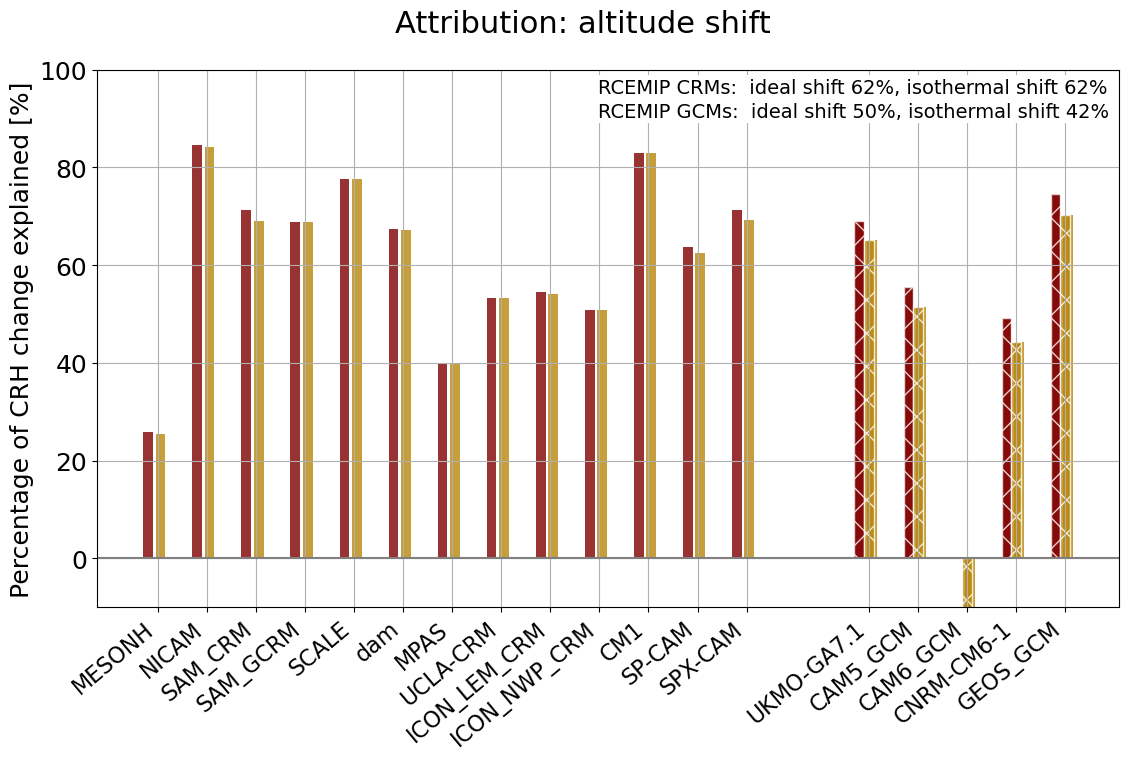

In [22]:
#FIGURE EXTENDED DATA 2
varnames = ['explained_isoth_shift','explained_isoshift_dens','explained_isoshift_iris']
cols = ['maroon','darkgoldenrod']
mmm = np.array(['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam','MPAS','UCLA-CRM','CAM5_GCM',
            'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1'])
idx = [0,1,2,3,4,5,6,7,12,13,17,14,15,16,8,9,10,11]
models = mmm[idx] #turn the order

fig = plt.figure()

fig.set_size_inches(12,8,forward=True)
gs = gridspec.GridSpec(1,1,height_ratios=[1],width_ratios=1*[1])

ax = fig.add_subplot(gs[0,0])

x_pos = np.arange(len(models)+4)
mod_xpos=np.concatenate((x_pos[:13], [14.5,15.5,16.5,17.5,18.5]), axis=0)
for m in range(0,len(models)):
    if m<(len(models)):
        plt.bar(mod_xpos[m],e_all_expl_shift[m,0],color=cols[0],width=0.2,alpha=0.8,label=model)# ideal shift
        
        plt.bar(mod_xpos[m]+0.25,e_all_expl_shift[m,1],color=cols[1],width=0.2,alpha=0.8)  #physical shift
        
        if m in (13,14,15,16,17): #GCMs - SP CAM
            plt.bar(mod_xpos[m],e_all_expl_shift[m,0],color=cols[0],width=0.2,alpha=0.8,hatch='x',ec='w')# ideal shift
            plt.bar(mod_xpos[m]+0.2,e_all_expl_shift[m,1],color=cols[1],width=0.2,alpha=0.8,hatch='x',ec='w')  #physical shift    

ax.set_xticks(mod_xpos+0.2, models, rotation=40, ha='right',size=16)

plt.text(0.49,0.985,'RCEMIP CRMs:  ideal shift 62%, isothermal shift 62%',transform=ax.transAxes,horizontalalignment='left',
verticalalignment='top',fontsize=14,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=2))

plt.text(0.49,0.94,'RCEMIP GCMs:  ideal shift 50%, isothermal shift 42%',transform=ax.transAxes,horizontalalignment='left',
verticalalignment='top',fontsize=14,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=2))

plt.axhline(y=0,color='gray')
plt.ylabel('Percentage of CRH change explained [%]')

plt.ylim(-10,100)
plt.suptitle('Attribution: altitude shift',fontsize=22,y=0.96)
plt.grid(True)
plt.tight_layout()
#plt.savefig('/path-to-figure/FigEXT2_ATTRIBUTION_shift_explained_RCElarge.pdf',dpi=200,bbox_inches='tight')  

In [23]:
#[e_idshift[m], e_shift[m], e_intshift[m],e_densfac[m],e_dens_qi[m]]

In [24]:
#for ideal intensity change contribution only!!!
#1. GCMs only
np.nanmean(e_all_expl_shift[13:,2] - e_all_expl_shift[13:,0],axis=0)

22.599999999999998

In [25]:
#for ideal intensity change contribution only!!!
#2. CRMs only
np.nanmean(e_all_expl_shift[:13,2] - e_all_expl_shift[:13,0],axis=0)

18.71538461538461

In [26]:
#for density contribution only!!!
#1. GCMs only
np.nanmean(e_all_expl_shift[13:,3] - e_all_expl_shift[13:,0],axis=0)
#np.nanmean(e_all_expl_shift[:13,3] - e_all_expl_shift[:13,1],axis=0)

-22.76

In [27]:
#for density contribution only!!!
#2. CRMs only
np.nanmean(e_all_expl_shift[:13,3] - e_all_expl_shift[:13,0],axis=0)

8.892307692307693

In [28]:
#for ice contribution only!!!#for density contribution only!!!
#1. GCMs only
np.nanmean(e_all_expl_shift[13:,4] - e_all_expl_shift[13:,3],axis=0)

40.06

In [29]:
#for ice contribution only!!!
#2. CRMs only
np.nanmean(e_all_expl_shift[:13,4] - e_all_expl_shift[:13,3],axis=0)

4.676923076923078

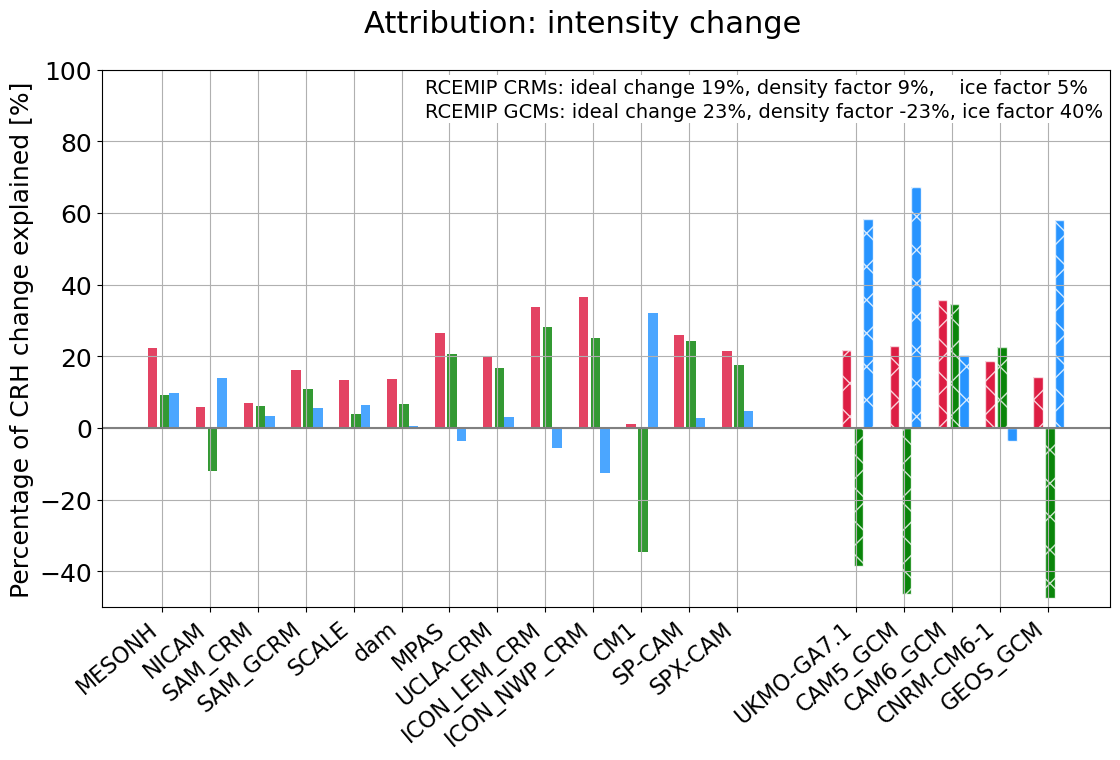

In [30]:
#FIGURE EXTENDED DATA 3
cols = ['crimson','g','dodgerblue']

fig = plt.figure()

fig.set_size_inches(12,8,forward=True)
gs = gridspec.GridSpec(1,1,height_ratios=[1],width_ratios=1*[1])

ax = fig.add_subplot(gs[0,0])

x_pos = np.arange(len(models)+4)
mod_xpos=np.concatenate((x_pos[:13], [14.5,15.5,16.5,17.5,18.5]), axis=0)
for m in range(0,len(models)):
    if m<(len(models)):
        plt.bar(mod_xpos[m],e_all_expl_shift[m,2] - e_all_expl_shift[m,0],color=cols[0],width=0.2,alpha=0.8,label=model)# ideal shift
        
        plt.bar(mod_xpos[m]+0.25,e_all_expl_shift[m,3]- e_all_expl_shift[m,1],color=cols[1],width=0.2,alpha=0.8)  #physical shift
        
        plt.bar(mod_xpos[m]+0.45,e_all_expl_shift[m,4]- e_all_expl_shift[m,3],color=cols[2],width=0.2,alpha=0.8)   #shift only
        if m in (13,14,15,16,17): #GCMs - SP CAM
            plt.bar(mod_xpos[m],e_all_expl_shift[m,2]-e_all_expl_shift[m,0],color=cols[0],width=0.2,alpha=0.8,hatch='x',ec='w')# ideal shift
            plt.bar(mod_xpos[m]+0.25,e_all_expl_shift[m,3]-e_all_expl_shift[m,1],color=cols[1],width=0.2,alpha=0.8,hatch='x',ec='w')  #physical shift
            plt.bar(mod_xpos[m]+0.45,e_all_expl_shift[m,4]-e_all_expl_shift[m,3],color=cols[2],width=0.2,alpha=0.8,hatch='x',ec='w')   #shift only     

ax.set_xticks(mod_xpos+0.2, models, rotation=40, ha='right',size=16)

plt.text(0.32,0.94,'RCEMIP GCMs: ideal change 23%, density factor -23%, ice factor 40%',transform=ax.transAxes,horizontalalignment='left',
verticalalignment='top',fontsize=14,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=2))


plt.text(0.32,0.985,'RCEMIP CRMs: ideal change 19%, density factor 9%,    ice factor 5%',transform=ax.transAxes,horizontalalignment='left',
verticalalignment='top',fontsize=14,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=2))

plt.axhline(y=0,color='gray')
plt.ylabel('Percentage of CRH change explained [%]')

plt.ylim(-50,100)
plt.suptitle('Attribution: intensity change',fontsize=22,y=0.96)
plt.grid(True)
plt.tight_layout()
#plt.savefig('/path-to-file/FigEXT3_ATTRIBUTION_intensity_explained_RCElarge.pdf',dpi=200,bbox_inches='tight')  